This is a simple Transformer test with the goal to train to predict a sine wave using PyTorch.

In [117]:
# Created by Davide Pasca - 2023/07/30

# Ensure that the notebook can see the data dir (Google Colab only)
import os
def is_colab():
  try:
    import google.colab
    return True
  except ImportError:
    return False

if is_colab():
  repo = 'dpasca-pytorch-examples'
  full_path = f'/content/drive/MyDrive/dev/repos/{repo}'

  if os.getcwd() != full_path:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd {full_path}

  %pwd

import torch
import torch.nn as nn
import torch.optim as optim
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from typing import Tuple

In [118]:
import subprocess
import torch

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    #print(subprocess.check_output(["nvidia-smi"], encoding="utf-8").strip())
    print(subprocess.check_output(["nvidia-smi", "-L"], encoding="utf-8").strip())
    print("Torch CUDA version:", torch.version.cuda)
elif torch.backends.mps.is_available():
    device = "mps"

print("Using device:", device)

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-e6d18069-f77a-ca2a-0183-450c04ae7f35)
Torch CUDA version: 11.8
Using device: cuda


In [119]:
# Constants

SAMPLE_SIZE_HOURS = int(6)
SAMPLE_SIZE_MINS = 60 * SAMPLE_SIZE_HOURS  # 6 hours

USE_LOG_RETURNS = False

# Gradient accumulation steps
ACCUMULATION_STEPS = 10

if True: # quick test
    SEQUENCE_LENGTH_MINS = 30*24*60 # days * 24 * 60
    SEQUENCE_LENGTH = SEQUENCE_LENGTH_MINS // SAMPLE_SIZE_MINS
    TRAIN_DATES = ['2020-01-01', '2022-12-31']
    TEST_DATES  = ['2023-01-01', '2023-07-23']
else:
    SEQUENCE_LENGTH_MINS = 30*24*60 # days * 24 * 60
    SEQUENCE_LENGTH = SEQUENCE_LENGTH_MINS // SAMPLE_SIZE_MINS
    TRAIN_DATES = ['2017-01-01', '2022-12-31']
    TEST_DATES  = ['2023-01-01', '2023-07-23']

print(f'SAMPLE_SIZE_HOURS: {SAMPLE_SIZE_HOURS}')
print(f'USE_LOG_RETURNS: {USE_LOG_RETURNS}')
print(f'ACCUMULATION_STEPS: {ACCUMULATION_STEPS}')
print(f'SEQUENCE_LENGTH: {SEQUENCE_LENGTH}')
print(f'TRAIN_DATES: {TRAIN_DATES}')
print(f'TEST_DATES: {TEST_DATES}')

SAMPLE_SIZE_HOURS: 6
USE_LOG_RETURNS: False
ACCUMULATION_STEPS: 10
SEQUENCE_LENGTH: 120
TRAIN_DATES: ['2020-01-01', '2022-12-31']
TEST_DATES: ['2023-01-01', '2023-07-23']


In [120]:
import requests
import json
import time
import datetime

def get_klines_req(symbol, interval, start_time, limit=500):
    url = 'https://api.binance.com/api/v3/klines'

    # Define the parameters
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': limit
    }

    response = requests.get(url, params=params)
    data = json.loads(response.text)

    # Convert the data to a more readable format
    readable_data = []
    for candle in data:
        time_stamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(candle[0]/1000))
        ohlcv = candle[1:6]
        readable_candle = [time_stamp] + ohlcv
        readable_data.append(readable_candle)

    return readable_data

def get_klines(symbol, interval, start_date, end_date):
    # Convert the start and end dates to milliseconds
    start_time = int(start_date.timestamp() * 1000)
    end_time = int(end_date.timestamp() * 1000)

    # Fetch historical data for Bitcoin with 6 hours candles
    btc_data = []
    while True:
        new_data = get_klines_req(symbol, interval, start_time)
        if not new_data:
            break
        last_time = new_data[-1][0]
        last_time_dt = datetime.datetime.strptime(last_time, '%Y-%m-%d %H:%M:%S')
        last_time_millis = int(last_time_dt.timestamp() * 1000)
        if last_time_millis >= end_time:
            # Clamp candles that go beyond the end date
            new_data = [candle for candle in new_data if int(datetime.datetime.strptime(candle[0], '%Y-%m-%d %H:%M:%S').timestamp() * 1000) < end_time]
        btc_data += new_data
        if last_time_millis >= end_time:
            break
        start_time = last_time_millis + 1
        time.sleep(0.1)  # delay to avoid hitting rate limits

    return btc_data

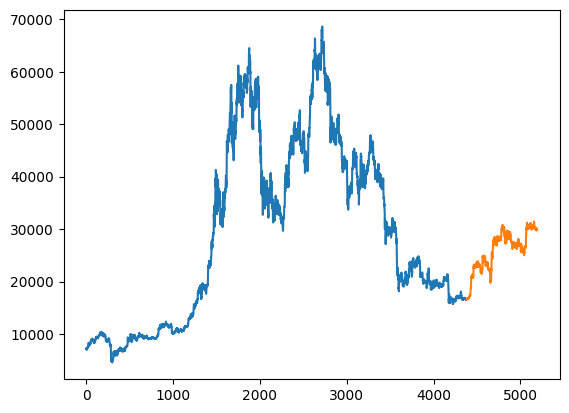

In [121]:
import os
import pickle

def get_closing_prices_in_range(res : str, datesYMD : list):
    start_YMD, end_YMD = datesYMD
    start_date = datetime.datetime.strptime(start_YMD, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_YMD, '%Y-%m-%d')

    # Create a cache directory if it doesn't exist
    cache_dir = 'market_data_cache'
    os.makedirs(cache_dir, exist_ok=True)

    # Create a cache file name based on the start and end dates
    cache_file = os.path.join(cache_dir,
                        'btc_usdt_{}_binance_data_{}_{}.pickle'
                        .format(res, start_YMD, end_YMD))

    # Check if the cache file exists
    if os.path.exists(cache_file):
        # If the cache file exists, load the data from the file
        with open(cache_file, 'rb') as f:
            btc_data = pickle.load(f)
    else:
        # If the cache file doesn't exist, fetch the data and save it to the cache file
        btc_data = get_klines('BTCUSDT', res, start_date, end_date)
        with open(cache_file, 'wb') as f:
            pickle.dump(btc_data, f)

    return [float(candle[4]) for candle in btc_data]

# Split the data into training and test sets
resolution = str(SAMPLE_SIZE_HOURS) + 'h'
train_y = torch.tensor(get_closing_prices_in_range(resolution, TRAIN_DATES))
test_y  = torch.tensor(get_closing_prices_in_range(resolution, TEST_DATES))

# plot train and test data
plt.plot(train_y, label='Train Data')
plt.plot(range(len(train_y), len(train_y) + len(test_y)), test_y, label='Test Data')
plt.show()

In [122]:
def create_sequences(input_data, seq_length):
    sequences = []

    if USE_LOG_RETURNS:
        # Compute the log returns. We'll shift the input data by 1 element to compute the difference in logs.
        use_input_data = torch.log(input_data[1:]) - torch.log(input_data[:-1])
        # Normalize log returns
        use_input_data = (use_input_data - torch.mean(use_input_data)) / torch.std(use_input_data)
    else:
        use_input_data = (input_data - torch.mean(input_data)) / torch.std(input_data)

    # The 'unfold' function is used to create sliding windows over the data.
    #   1st argument is the dimension along which to unfold (0: time dimension)
    #   2nd argument is the size of each slice (seq_length + 1)
    #     We add 1 because each sequence consists of 'seq_length' elements plus 1 label.
    #   3rd argument is the step between each slice (1)
    #     This means that each sequence will start 1 time step after the prev sequence
    seq = use_input_data.unfold(0, seq_length + 1, 1)

    # 'seq' is now a 2D tensor where each row is a sequence.
    # We can convert it back to a list of sequences using a list comprehension
    # For each sequence in 'seq', we treat the last element as the label and the rest as the input sequence
    # So, s[:-1] is the input sequence and s[-1] is the label.
    sequences = [(s[:-1], s[-1]) for s in seq]

    return sequences

# Create the sequences
train_sequences = create_sequences(train_y, SEQUENCE_LENGTH)
test_sequences = create_sequences(test_y, SEQUENCE_LENGTH)

# Convert sequences to numpy arrays first, then to PyTorch tensors
train_sequence_data = [
    (torch.from_numpy(np.array(seq)).unsqueeze(1).float().to(device),
     label.clone().detach().float().to(device))
    for seq, label in train_sequences]

test_sequence_data = [
    (torch.from_numpy(np.array(seq)).unsqueeze(1).float().to(device),
     label.clone().detach().float().to(device))
    for seq, label in test_sequences]


In [123]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, seq_len=50, num_layers=2, hidden_dim=128):
        super(TransformerModel, self).__init__()
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=1,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_dim
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Transform the input sequence using the embedding layer.
        # This converts each input value into a dense vector of size 'hidden_dim'.
        x = self.embedding(x)
        # Shift the input sequence one step to the right to create the target sequence.
        # Zero-pad the shifted sequence at the beginning to maintain the same length.
        tgt = torch.cat(
            [torch.zeros(1, 1, self.hidden_dim, device=device),
                x[:-1,:,:]], # Exclude last sequence from x
                dim=0)
        x = self.transformer(x, tgt)
        x = self.fc(x) # Apply last layer, hidden_dim -> output_dim
        return x

model = TransformerModel()
model = model.to(device)

In [124]:
def print_report(epoch, epochs, epochs_per_sec, train_losses, target_losses, test_sequence_data, test_predictions):
    # Plot losses and predictions
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

    # Plot losses
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(target_losses, label='Target Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Plot the actual values and the predictions
    axs[1].plot([label.item() for _, label in test_sequence_data], label='Actual')
    axs[1].plot(test_predictions, label='Predicted')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel('Normalized Value')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()

    clear_output(wait=True)
    # make str of epochs per second or epoch per minute
    perf_str = (f'{epochs_per_sec:.3f}/sec' if epochs_per_sec > 1.0 else f'{60.0*epochs_per_sec:.3f}/min')
    print(f'Epoch {epoch+1}/{epochs} ({perf_str}), Train loss: {train_losses[-1]:.5f}, Target loss: {target_losses[-1]:.5f}')
    plt.show()

Epoch 18/100 (1.017/min), Train loss: 0.05855, Target loss: 0.33622


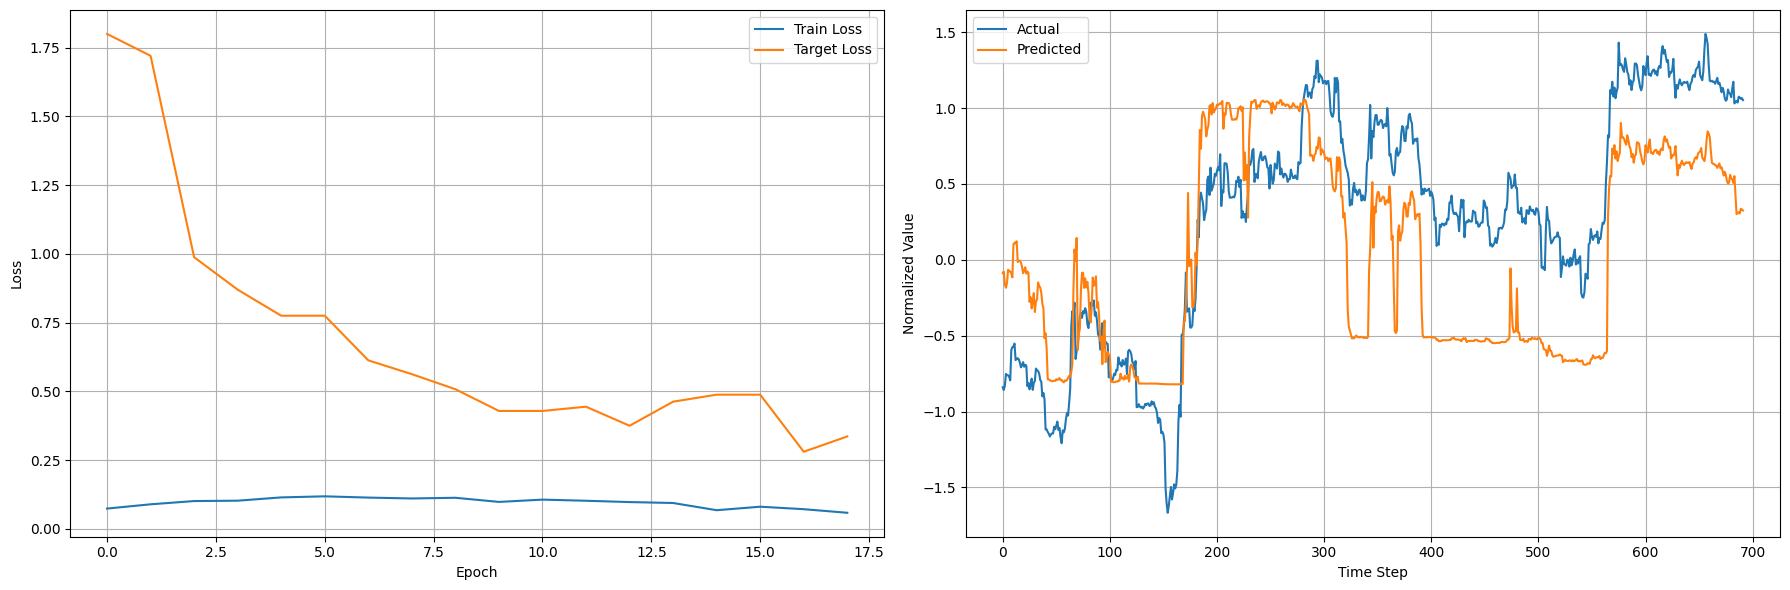

In [ ]:
# torch seed to 0
torch.manual_seed(0)

# Define loss function and optimizer
criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# Number of epochs
epochs = 100

# For storing losses
train_losses = []
target_losses = []

# For plotting losses
plt.ion()

last_update_time = time.time()
last_update_epoch = -1

for epoch in range(epochs):
    train_loss = 0.0
    optimizer.zero_grad()  # Reset the gradients outside the accumulation loop

    for i, (seq, label) in enumerate(train_sequence_data):
        seq = seq.unsqueeze(1)  # Add batch dimension
        output = model(seq).squeeze()  # Forward pass

        # Compute the loss, and sum the losses over the batch
        loss = criterion(output[-1], label.squeeze())
        train_loss += loss.item()

        loss.backward()  # accumulates the gradient

        if (i+1) % ACCUMULATION_STEPS == 0:  # Update weights every ACCUMULATION_STEPS batches
            optimizer.step()  # Update the weights
            optimizer.zero_grad()  # Reset gradients

    # make sure to update the weights one last time if the last batch was smaller than ACCUMULATION_STEPS
    if (i+1) % ACCUMULATION_STEPS != 0:
        optimizer.step()
        optimizer.zero_grad()

    # Average training loss for this epoch
    train_loss /= len(train_sequence_data)
    train_losses.append(train_loss)

    # rest of the loop...
    is_edge_epoch = (epoch == 0 or epoch == epochs - 1)

    # Compute loss on target data
    if is_edge_epoch or (epoch % 5):
      target_loss = 0
      for seq, label in test_sequence_data:
          seq = seq.unsqueeze(1)
          output = model(seq).squeeze()
          target_loss += criterion(output[-1], label.squeeze()).item()
      target_loss /= len(test_sequence_data)
      target_losses.append(target_loss)
    else:
      # append the previous target loss
      target_losses.append(target_losses[-1])

    # Print losses
    cur_time = time.time()
    if cur_time > (last_update_time+5) or is_edge_epoch:
        dt = cur_time - last_update_time
        epochs_per_sec = ((epoch - last_update_epoch) / dt if dt > 0 else 0.0)
        last_update_time = cur_time
        last_update_epoch = epoch

        model.eval()
        # Generate predictions on the test set
        test_predictions = []
        for seq, label in test_sequence_data:
            seq = seq.unsqueeze(1)
            output = model(seq)
            test_predictions.append(output[-1].item())
        model.train()

        print_report(
           epoch,epochs, epochs_per_sec, train_losses, target_losses, test_sequence_data, test_predictions)
        #print(f'{epochs_per_sec}/sec' if epochs_per_sec > 1.0 else f'{60*epochs_per_sec}/min')

plt.ioff()